In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.model_selection import KFold,GroupKFold
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()

In [9]:
#!pip install scikit-learn --user
#!pip install seaborn --user
#!pip install xgboost --user

### 导入数据

In [45]:
power_history_train = pd.read_csv('../初赛1008/训练集/power_forecast_history.csv')

In [46]:
power_history_train['tag']='train'

In [47]:
power_history_test = pd.read_csv('../初赛1008/测试集/power_forecast_history.csv')

In [48]:
power_history_test['tag']='test'

In [49]:
power_history = pd.concat([power_history_train,power_history_test])

In [50]:
power_history

,id_encode,hour,ele_price,ser_price,after_ser_price,total_price,f1,f2,f3,ds,tag
0,0,0.0,0.64,0.95,0.31,1.59,0.0,0.0,1.0,20220415,train
1,0,1.0,0.64,0.95,0.31,1.59,0.0,0.0,1.0,20220415,train
2,0,2.0,0.64,0.95,0.31,1.59,0.0,0.0,1.0,20220415,train
3,0,3.0,0.64,0.95,0.31,1.59,0.0,0.0,1.0,20220415,train
4,0,4.0,0.64,0.95,0.31,1.59,0.0,0.0,1.0,20220415,train
...,...,...,...,...,...,...,...,...,...,...,...
83995,499,19.0,0.00,0.51,0.51,0.51,3.0,1240.0,NaN,20230421,test
83996,499,20.0,0.00,0.51,0.51,0.51,3.0,1240.0,NaN,20230421,test
83997,499,21.0,0.00,0.51,0.51,0.51,3.0,1240.0,NaN,20230421,test
83998,499,22.0,0.00,0.51,0.51,0.51,3.0,1240.0,NaN,20230421,test


In [41]:
#重构数据，以天为单位
power_history = power_history.groupby(['id_encode','ds','tag'])['ele_price','ser_price','after_ser_price',
                                                       'total_price','f1','f2','f3'].mean().reset_index()

C:\Users\LSNEV\AppData\Local\Temp\ipykernel_20844\2686535894.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  power_history = power_history.groupby(['id_encode','ds','tag'])['ele_price','ser_price','after_ser_price',


In [42]:
power_history.head()

,id_encode,ds,tag,ele_price,ser_price,after_ser_price,total_price,f1,f2,f3
0,0,20220415,train,0.64,0.95,0.31,1.59,0.0,0.0,1.0
1,0,20220416,train,0.64,0.95,0.31,1.59,0.0,0.0,1.0
2,0,20220417,train,0.64,0.95,0.31,1.59,0.0,0.0,1.0
3,0,20220418,train,0.64,0.95,0.31,1.59,0.0,0.0,1.0
4,0,20220419,train,0.64,0.95,0.31,1.59,0.0,0.0,1.0


In [21]:
# power = pd.read_csv('../raw_data/train/power.csv')
power = pd.read_csv('../初赛1008//训练集/power.csv')

In [ ]:
power = power.groupby(['id_encode','ds'])['power'].sum().reset_index()

In [34]:
# stub_info = pd.read_csv('../raw_data/train/stub_info.csv')
stub_info = pd.read_csv('../初赛1008//训练集/stub_info.csv')

### 可视化EDA

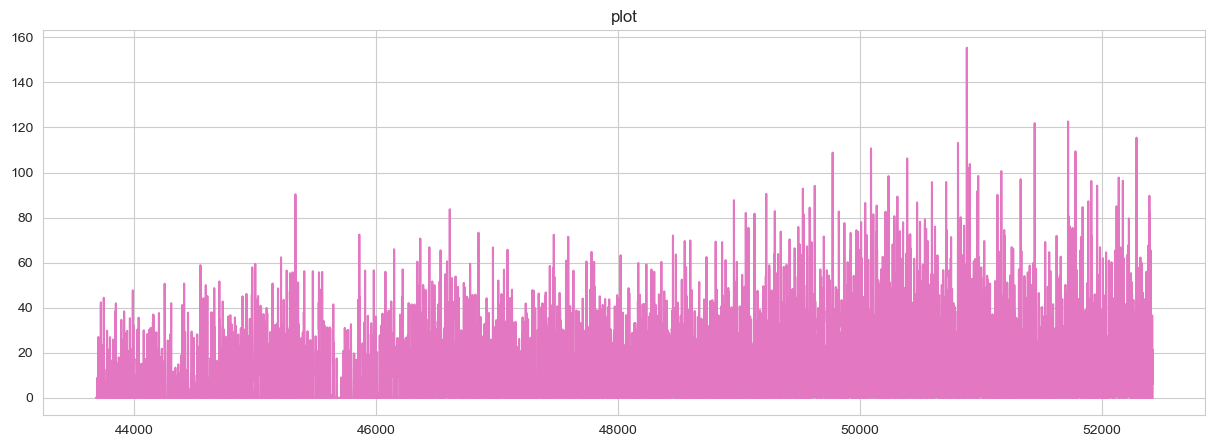

In [35]:
power[power['id_encode']==5]['power'].plot(style='-',
        figsize=(15, 5),
        color=color_pal[6],
        title='plot')
plt.show()

<AxesSubplot:ylabel='Frequency'>

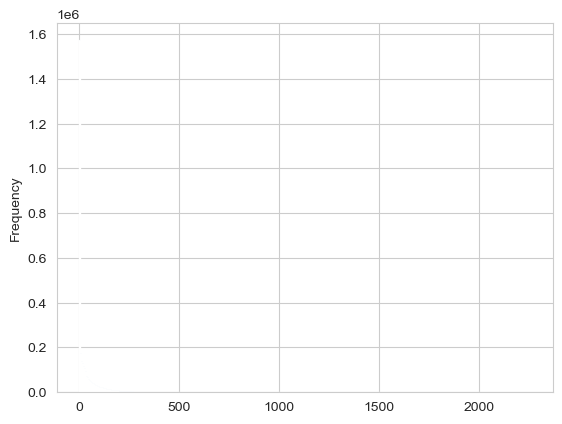

In [37]:
power['power'].plot(kind='hist', bins=500)

In [39]:
power_history

,id_encode,ds,tag,ele_price,ser_price,after_ser_price,total_price,f1,f2,f3,hour,power
0,0,20220415,train,0.64,0.95,0.31,1.59,0.0,0.0,1.0,0.0,0.0
1,0,20220415,train,0.64,0.95,0.31,1.59,0.0,0.0,1.0,1.0,0.0
2,0,20220415,train,0.64,0.95,0.31,1.59,0.0,0.0,1.0,2.0,0.0
3,0,20220415,train,0.64,0.95,0.31,1.59,0.0,0.0,1.0,3.0,0.0
4,0,20220415,train,0.64,0.95,0.31,1.59,0.0,0.0,1.0,4.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
3569879,499,20230417,test,0.00,0.51,0.51,0.51,3.0,1240.0,NaN,NaN,NaN
3569880,499,20230418,test,0.00,0.51,0.51,0.51,3.0,1240.0,NaN,NaN,NaN
3569881,499,20230419,test,0.00,0.51,0.51,0.51,3.0,1240.0,NaN,NaN,NaN
3569882,499,20230420,test,0.00,0.51,0.51,0.51,3.0,1240.0,NaN,NaN,NaN


#### 合并数据集

In [36]:
power_history = power_history.merge(power,on=['id_encode','ds'],how='left')

In [ ]:
power_history = power_history.merge(stub_info,on=['id_encode'],how='left')

In [ ]:
#删除训练集power为空的
power_history = power_history[~((power_history['tag']=='train')&(power_history['power'].isnull()))]

### 特征工程

In [ ]:
#时间滞后特征
for i in range(7, 14):
    power_history['lag_{}'.format(i)]=power_history.groupby('id_encode')['power'].shift(i)

In [ ]:
power_history['date'] = pd.to_datetime(power_history['ds'].astype(str),format='%Y-%m-%d')

In [ ]:
power_history = power_history.reset_index(drop=True)

In [ ]:
#Create time series features
power_history['dayofweek'] = power_history['date'].dt.dayofweek
power_history['quarter'] = power_history['date'].dt.quarter
power_history['month'] = power_history['date'].dt.month
power_history['dayofyear'] = power_history['date'].dt.dayofyear
power_history['day'] = power_history['date'].dt.day
power_history['weekofyear'] = power_history['date'].dt.weekofyear

In [ ]:
df=power_history.copy()

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['h3'] = le.fit_transform(df['h3'])

In [ ]:
df['flag'] = df['flag'].replace({'A':1,'B':2})

In [ ]:
df['flag'].value_counts()

In [ ]:
feat = [i for i in df.columns if i not in['ds','date','power','tag']]

In [ ]:
train_x=df[df['tag']=='train'][feat]

In [ ]:
train_y=df[df['tag']=='train']['power']

In [ ]:
test = df[df['tag']=='test'][feat]

In [ ]:
test_p = df[df['tag']=='test'][['id_encode','ds']]

### 建模

In [ ]:
folds = 5
seed = 2020
kf = KFold(n_splits=folds, shuffle=True, random_state=seed)

#fold = 0
preds = []
oof = np.zeros(train_x.shape[0])
pred = np.zeros(test.shape[0])

scores = []
for train_idx, val_idx in kf.split(train_x, train_y):
    X_train = train_x.iloc[train_idx]
    y_train = train_y.iloc[train_idx]

    X_test = train_x.iloc[val_idx]
    y_test = train_y.iloc[val_idx]

    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                           n_estimators=5000,
                           early_stopping_rounds=50,
                           objective='reg:squarederror',
                           max_depth=7,
                           learning_rate=0.01)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    y_pred = reg.predict(X_test)
    oof[val_idx] =y_pred
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)
    print('cv_score:',scores)
    
    test_pred = reg.predict(test)
    pred += test_pred / kf.n_splits
    

In [ ]:
pred

In [ ]:
test_p['power']=pred

In [ ]:
test_p[test_p['power']<0]

In [ ]:
test_p['power']=test_p['power'].apply(lambda x : 0 if x<0 else x)

In [ ]:
test_p

In [ ]:
#sub = test_p.groupby(['id_encode','ds'])['power'].sum().reset_index()

In [ ]:
sub=test_p.copy()

In [ ]:
sub.to_csv('sub.csv',index=False)

### 结果可视化

In [ ]:
trian_dd = df[(df['tag']=='train')][['id_encode','ds','power']]
trian_dd = trian_dd.set_index('ds')

In [ ]:
test_dd = test_p.copy()
test_dd = test_dd.set_index('ds')

In [ ]:
fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)
for i in range(5):
    trian_dd[trian_dd['id_encode']==i]['power'][-60:].plot(ax=axs[i],
                      label='Training Set',
                      title='Data Train/Test Split-id_encode-{}'.format(i))
    test_dd[test_dd['id_encode']==i]['power'].plot(ax=axs[i],
                     label='Test Set')
    axs[i].axvline(test_dd.index.min(), color='black', ls='--')